In [18]:
#Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
#Load Input File 
#File contains information regarding flight delays for January, June, July, August, November, December month of 2016
path = 'F:\\Study\\OneDrive - The University of Texas at Dallas\\02 Study\\12 Startup.ML\\Files\\Input_File\\'
path_file = path+'flight_data.csv'
flight_data = pd.read_csv(path_file)
 

In [9]:
flight_data.head()


,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,...,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,Unnamed: 42
0,1,1,3,7,2016-01-03,F9,694,11292,1129202,30325,...,87.0,1.0,692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,3,7,2016-01-03,F9,809,14027,1402702,34027,...,224.0,1.0,1679.0,19.0,0.0,0.0,0.0,0.0,NaN,NaN
2,1,1,3,7,2016-01-03,F9,907,15356,1535602,35356,...,60.0,1.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,3,7,2016-01-03,F9,908,14492,1449202,34492,...,57.0,1.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,3,7,2016-01-03,F9,915,15356,1535602,35356,...,107.0,1.0,693.0,2.0,0.0,18.0,0.0,0.0,NaN,NaN


In [10]:
print(flight_data.shape)

(2846155, 43)


In [12]:
#Create a Variable called Delayed, Flight is considered to be delayed if arrival delay is more than or equal to 15 minutes
flight_data['Delayed'] = np.where(flight_data['ARR_DELAY'] >=15, 1,0)

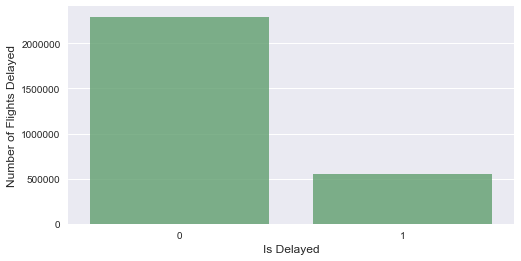

In [15]:
#Distribution of Number of flights Delayed
is_delayed = flight_data['Delayed'].value_counts()

plt.figure(figsize=(8,4))
color = sns.color_palette()
sns.barplot(is_delayed.index, is_delayed.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Flights Delayed', fontsize=12)
plt.xlabel('Is Delayed', fontsize=12)
plt.show()



In [16]:
#percentage of flights delayed (arrival time more than or equal to 15minutes)
print (flight_data['ARR_DELAY'][flight_data['ARR_DELAY'] >= 15].count())
print (flight_data.shape[0] - flight_data.CARRIER_DELAY.isnull().sum().sum())
flight_delay =flight_data['ARR_DELAY'][flight_data['ARR_DELAY'] >= 15].count()/flight_data.shape[0]
print("Percentage of Flights Delayed for More Than 15 Minutes:  {:.2%}".format(flight_delay))

550729
550729
Percentage of Flights Delayed for More Than 15 Minutes:  19.35%


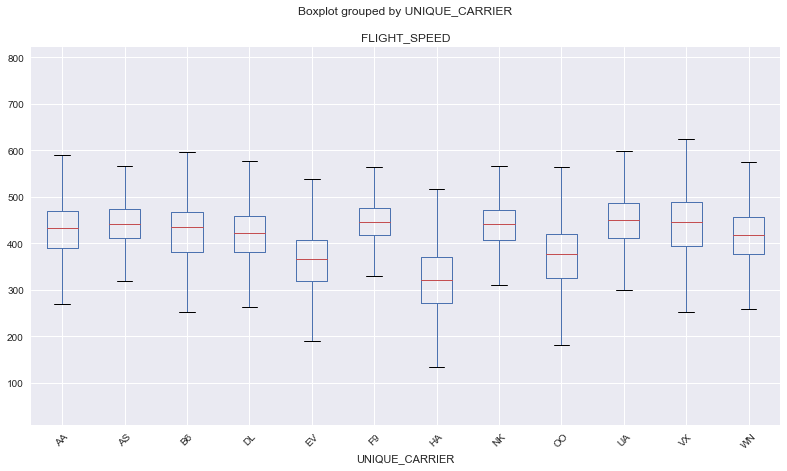

In [19]:
#Data Exploration
#Distribution of flight speed as speed of aircraft can cause arrival delay 
flight_data['FLIGHT_SPEED'] = 60*flight_data['DISTANCE']/flight_data['AIR_TIME']
flight_data[['UNIQUE_CARRIER','FLIGHT_SPEED']].boxplot(column = 'FLIGHT_SPEED',by='UNIQUE_CARRIER',figsize=(13,7),rot=45)

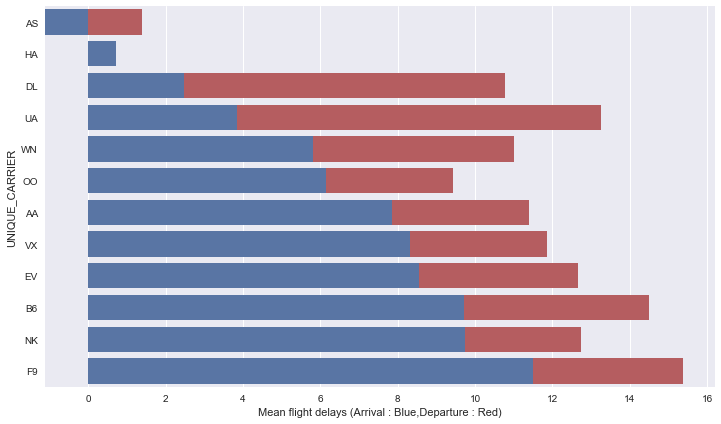

In [26]:
#Arrival and Departure Delay
df_delay = pd.DataFrame(flight_data.groupby('UNIQUE_CARRIER')[['ARR_DELAY','DEP_DELAY']].mean())
df_delay.sort_values(['ARR_DELAY','DEP_DELAY'],ascending = [1,1],inplace=True)
plt.figure(figsize=(12,7))
sns.set_color_codes("deep")
sns.set_context(font_scale=2.5)
plot = sns.barplot(x='DEP_DELAY',y=df_delay.index,data = df_delay,color = 'r')
plot = sns.barplot(x='ARR_DELAY',y=df_delay.index,data = df_delay,color = 'b')
plot.set(xlabel='Mean flight delays (Arrival : Blue,Departure : Red)')

In [28]:
#Filter data for model building
flight_data_filtered = flight_data[['MONTH', 'DAY_OF_MONTH', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME','Delayed', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE']]
print("Shape of Flight data with null values: ",flight_data_filtered.shape)
#Drop null values from the data
flight_data_filtered = flight_data_filtered.dropna()
print("Shape of flight data without null values:", flight_data_filtered.shape)
flight_data_filtered_dummy = pd.get_dummies(flight_data_filtered)
flight_data_shuffle = shuffle(flight_data_filtered_dummy)
flight_data_shuffle.shape


Shape of Flight data with null values:  (2846155, 16)
Shape of flight data without null values: (2796517, 16)


(2796517, 27)

In [29]:
#Split data into test and train dataset
y = flight_data_shuffle['Delayed']
x = flight_data_shuffle.drop('Delayed',1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [31]:
print("Training Dataset independent vairable:",X_train.shape)
print("Training Dataset dependent vairable:",y_train.shape)
print("Test Dataset independent vairable:",X_test.shape)
print("Test Dataset dependent vairable:",y_test.shape)

Training Dataset independent vairable: (2237213, 26)
Training Dataset dependent vairable: (2237213,)
Test Dataset independent vairable: (559304, 26)
Test Dataset dependent vairable: (559304,)


In [39]:
#Train Logistic Model
logistic = LogisticRegression()
count = 0
model_iteraction = 0
while count < len(X_train):
    test_data_x = X_train[count:count+1000]
    test_data_y = y_train[count:count+1000]
    count = count + 1000
    print("Training Model iteration "+str(model_iteraction))
    logistic.fit(test_data_x,test_data_y)
    model_iteraction +=1
    

Training Model iteration 0
Training Model iteration 1
Training Model iteration 2
Training Model iteration 3
Training Model iteration 4
Training Model iteration 5
Training Model iteration 6
Training Model iteration 7
Training Model iteration 8
Training Model iteration 9
Training Model iteration 10
Training Model iteration 11
Training Model iteration 12
Training Model iteration 13
Training Model iteration 14
Training Model iteration 15
Training Model iteration 16
Training Model iteration 17
Training Model iteration 18
Training Model iteration 19
Training Model iteration 20
Training Model iteration 21
Training Model iteration 22
Training Model iteration 23
Training Model iteration 24
Training Model iteration 25
Training Model iteration 26
Training Model iteration 27
Training Model iteration 28
Training Model iteration 29
Training Model iteration 30
Training Model iteration 31
Training Model iteration 32
Training Model iteration 33
Training Model iteration 34
Training Model iteration 35
Tr

In [38]:
final_logistic = logistic.predict(X_test)
final_logistic = pd.DataFrame(final_logistic)
matrix = confusion_matrix(y_test, final_logistic)
print("Confusion Matrix:\n",matrix)
print("Accuracy Score: ",accuracy_score(y_test,final_logistic))

Confusion Matrix:
 [[447859   1402]
 [ 83874  26169]]
Accuracy Score:  0.847531932545


In [ ]:
#Above model can be used to predict the flight delay with approximately 84.75% delay 